# Initial Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE

# Dataset Selection

In [2]:
# This is just to get the latest dated dataset without changing the string manually
import os
latest_data_dir: list = [file for file in os.listdir() if file.startswith("df_steam")]

# Import and visualize
df_main: pd.DataFrame = pd.read_csv(latest_data_dir[0], na_values=['None'])

print(df_main.shape)
df_main.head()

(1000, 20)


,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu,languages,genre,tags
0,570,Dota 2,Valve,Valve,NaN,1620812,341671,0,"200,000,000 .. 500,000,000",38131,1313,879,730,0,0,0,520119,"English, Bulgarian, Czech, Danish, Dutch, Finn...",Action;Free to Play;Strategy,Free to Play;MOBA;Multiplayer;Strategy;e-sport...
1,730,Counter-Strike: Global Offensive,"Valve, Hidden Path Entertainment",Valve,NaN,6317781,810361,0,"50,000,000 .. 100,000,000",30485,759,5864,286,0,0,0,1223076,"English, Czech, Danish, Dutch, Finnish, French...",Action;Free to Play,FPS;Shooter;Multiplayer;Competitive;Action;Tea...
2,1172470,Apex Legends,Respawn Entertainment,Electronic Arts,NaN,523297,109790,0,"50,000,000 .. 100,000,000",7186,809,813,419,0,0,0,417985,"English, French, Italian, German, Spanish - Sp...",Action;Adventure;Free to Play,Free to Play;Multiplayer;Battle Royale;Shooter...
3,578080,PUBG: BATTLEGROUNDS,"KRAFTON, Inc.","KRAFTON, Inc.",NaN,1237022,927771,0,"50,000,000 .. 100,000,000",22055,691,6340,188,0,0,0,381064,"English, Korean, Simplified Chinese, French, G...",Action;Adventure;Free to Play;Massively Multip...,Survival;Shooter;Battle Royale;Multiplayer;FPS...
4,1063730,New World,Amazon Games,Amazon Games,NaN,177176,76296,0,"50,000,000 .. 100,000,000",7386,338,3225,167,3999,3999,0,23870,"English, French, Italian, German, Spanish - Sp...",Action;Adventure;Massively Multiplayer;RPG,Massively Multiplayer;Open World;MMORPG;RPG;Ad...


In [3]:
df_genres = pd.read_csv("genres.csv").dropna()

print(df_genres.shape)
df_genres.head()

(18, 1)


,genre
0,Action
1,Adventure
2,Animation & Modeling
3,Audio Production
4,Casual


In [4]:
df_tags = pd.read_csv("tags.csv").dropna()

print(df_tags.shape)
df_tags.head()

(394, 1)


,tag
0,1980s
1,1990's
2,2.5D
3,2D
4,2D Fighter


# Introduction

Todo: Introduction, motivations

# Data Cleaning & Manipulation

## Cleaning

### Phase 1: Dropping irrelevant columns & unplayed games

We start off with some simpler procedures. First we remove the data columns that we deem irrelevant to the analysis, which are the following, with reasons:

| Dropped column | Reason |
| -------------- | ------ |
| `developer`    | Too many unique values and contains special characters |
| `publisher`    | Too many unique values and contains special characters |
| `score_rank`   | All `NaN`
| `userscore`    | Almost all 0
| `discount`     | Too dependent on current time (arguably `ccu` too, but we keep it because it is more interesting)
| `initialprice` | Often matches `price` and is more of a historical data
| `languages`    | Personal choice, though an alternative analysis on English / non-English games may be interesting

We also drop any unplayed or 'barely-played' games. For this analysis we set this rule to be games with 10 or less concurrent users at time of data collection.

In [5]:
# Cleaning: Drop data that is likely not useful
drops = ["developer", "publisher", "score_rank", "userscore", "discount", "initialprice", "languages"]
df_steam = df_main.drop(drops, axis=1).dropna()

# Only games with more than 10 concurrent users
df_steam = df_steam[df_steam["ccu"] > 10]

print(df_steam.shape)
df_steam.head()

(901, 13)


,appid,name,positive,negative,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,ccu,genre,tags
0,570,Dota 2,1620812,341671,"200,000,000 .. 500,000,000",38131,1313,879,730,0,520119,Action;Free to Play;Strategy,Free to Play;MOBA;Multiplayer;Strategy;e-sport...
1,730,Counter-Strike: Global Offensive,6317781,810361,"50,000,000 .. 100,000,000",30485,759,5864,286,0,1223076,Action;Free to Play,FPS;Shooter;Multiplayer;Competitive;Action;Tea...
2,1172470,Apex Legends,523297,109790,"50,000,000 .. 100,000,000",7186,809,813,419,0,417985,Action;Adventure;Free to Play,Free to Play;Multiplayer;Battle Royale;Shooter...
3,578080,PUBG: BATTLEGROUNDS,1237022,927771,"50,000,000 .. 100,000,000",22055,691,6340,188,0,381064,Action;Adventure;Free to Play;Massively Multip...,Survival;Shooter;Battle Royale;Multiplayer;FPS...
4,1063730,New World,177176,76296,"50,000,000 .. 100,000,000",7386,338,3225,167,3999,23870,Action;Adventure;Massively Multiplayer;RPG,Massively Multiplayer;Open World;MMORPG;RPG;Ad...


### Phase 2: Genre Assignments

Todo: Present counts

In [6]:
import warnings
warnings.filterwarnings("ignore", 'This pattern is interpreted as a regular expression, and has match groups')

# Build data
genre_counts = []
for genre in df_genres['genre'].unique():
    genre_counts.append({"genre": genre, "count": df_main["genre"].str.contains(genre).fillna(False).to_numpy().sum()})

# Display tags and number of games with these tags
df_genre_counts = pd.DataFrame(genre_counts).sort_values(by = "count", ascending = False)
df_genre_counts.head(10)

,genre,count
0,Action,666
1,Adventure,356
8,Indie,354
11,RPG,243
7,Free to Play,204
15,Strategy,203
13,Simulation,185
9,Massively Multiplayer,122
4,Casual,111
6,Early Access,46


TODO: Justify choice of range

In [7]:
df_genre_counts

,genre,count
0,Action,666
1,Adventure,356
8,Indie,354
11,RPG,243
7,Free to Play,204
15,Strategy,203
13,Simulation,185
9,Massively Multiplayer,122
4,Casual,111
6,Early Access,46


TODO: Explain procedures?

In [8]:
chosen_genres = ['Adventure', 'RPG', 'Strategy', 'Casual']

df_assignments = pd.DataFrame(columns = ['appid', 'genre'])
for genre in chosen_genres:
    indexes = df_main["genre"].str.contains(genre).fillna(False).to_list()
    appids = df_main['appid'][indexes]
    
    df_temp = pd.DataFrame({'appid': appids, 'genre': genre})
    df_assignments = (
        df_assignments.merge(df_temp, on='appid', how = 'outer', indicator=True)
        .query("_merge != 'both'")
        .drop('_merge', axis = 1)
    )
    df_assignments['genre'] = df_assignments['genre_x'].combine_first(df_assignments['genre_y'])
    df_assignments = df_assignments.drop(['genre_x', 'genre_y'], axis = 1)
    
print(df_assignments.shape)
df_assignments.head()

(489, 2)


,appid,genre
0,1172470,Adventure
1,578080,Adventure
2,271590,Adventure
4,1085660,Adventure
5,901583,Adventure


TODO: Show final results

In [9]:
df_steam = (
    df_steam
    .drop(['genre', 'tags'], axis=1)
    .merge(df_assignments, on='appid', how='inner')
)

print(df_steam.shape)
df_steam.head()

(447, 12)


,appid,name,positive,negative,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,ccu,genre
0,570,Dota 2,1620812,341671,"200,000,000 .. 500,000,000",38131,1313,879,730,0,520119,Strategy
1,1172470,Apex Legends,523297,109790,"50,000,000 .. 100,000,000",7186,809,813,419,0,417985,Adventure
2,578080,PUBG: BATTLEGROUNDS,1237022,927771,"50,000,000 .. 100,000,000",22055,691,6340,188,0,381064,Adventure
3,271590,Grand Theft Auto V,1320557,219584,"50,000,000 .. 100,000,000",13724,736,6157,200,2998,111914,Adventure
4,230410,Warframe,460909,71760,"20,000,000 .. 50,000,000",10749,1356,404,764,0,48454,RPG


## Manipulation

In [10]:
# Manipulation

# df_steam["log_ccu"] = np.log(df_steam["ccu"])
df_steam["prop_review"] = df_steam["positive"] / (df_steam["positive"] + df_steam["negative"])

print(df_steam.shape)
df_steam.head()

(447, 13)


,appid,name,positive,negative,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,ccu,genre,prop_review
0,570,Dota 2,1620812,341671,"200,000,000 .. 500,000,000",38131,1313,879,730,0,520119,Strategy,0.825899
1,1172470,Apex Legends,523297,109790,"50,000,000 .. 100,000,000",7186,809,813,419,0,417985,Adventure,0.826580
2,578080,PUBG: BATTLEGROUNDS,1237022,927771,"50,000,000 .. 100,000,000",22055,691,6340,188,0,381064,Adventure,0.571427
3,271590,Grand Theft Auto V,1320557,219584,"50,000,000 .. 100,000,000",13724,736,6157,200,2998,111914,Adventure,0.857426
4,230410,Warframe,460909,71760,"20,000,000 .. 50,000,000",10749,1356,404,764,0,48454,RPG,0.865282


# Descriptive Analytics

In [11]:
df_numerical = df_steam.select_dtypes("number").drop(["appid", "ccu", "positive", "negative"], axis = 1)
df_numerical["prop_review"] = df_numerical["prop_review"].fillna(0)

df_numerical.head()

,average_forever,average_2weeks,median_forever,median_2weeks,price,prop_review
0,38131,1313,879,730,0,0.825899
1,7186,809,813,419,0,0.826580
2,22055,691,6340,188,0,0.571427
3,13724,736,6157,200,2998,0.857426
4,10749,1356,404,764,0,0.865282


In [12]:
# Store TSNE data to memory to save time trying plots out
# (RIP my RAM)
tsne_memo = {}
perplexities: list = [5, 10, 20, 30, 40, 50]
random_states: list = [207, 430]

for i in range(12):
    ppx = perplexities[np.floor_divide(i, 2)]
    rs = random_states[np.remainder(i, 2)]
    tsne_memo[i] = (
        TSNE(perplexity=ppx, random_state=rs)
        .fit_transform(df_numerical)
    )

In [13]:
# tl;dr The order the 'owners' category should be in, in order of number instead of string sort
# owners_order = np.argsort([int(s.split(' .. ')[0].replace(',', '')) for s in df_steam["owners"]])

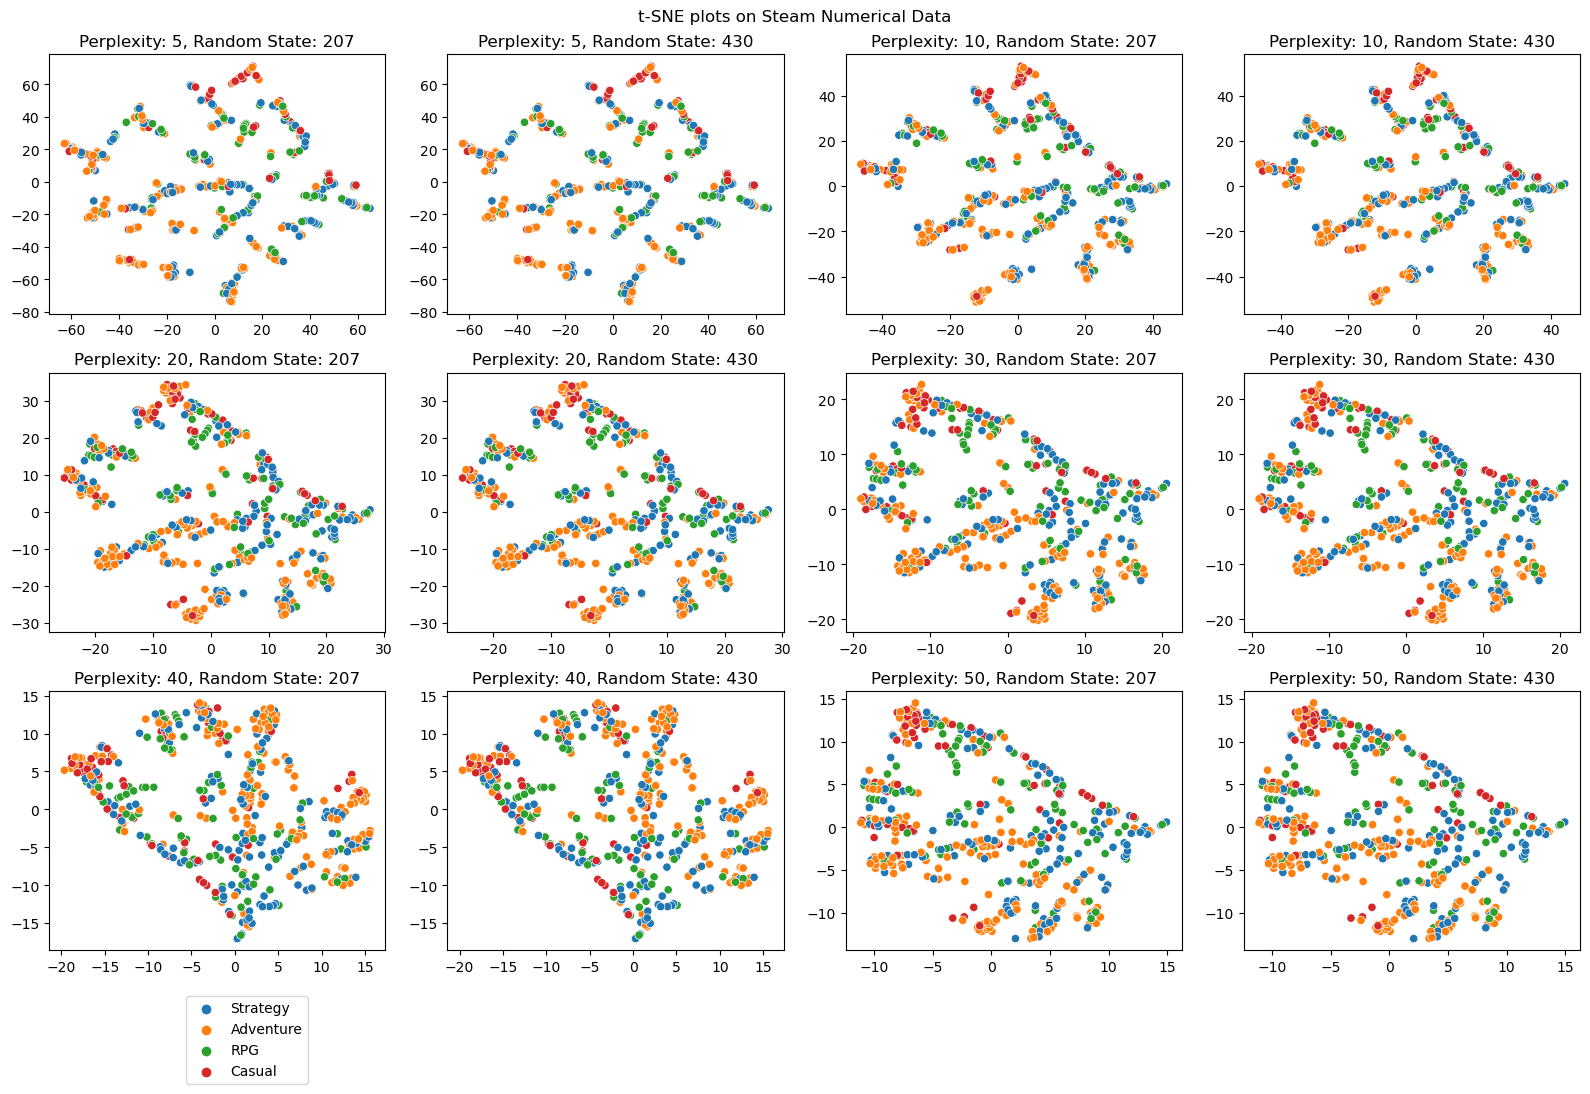

In [14]:
fig, axs = plt.subplots(3, 4, figsize = (16, 10))

plt.suptitle("t-SNE plots on Steam Numerical Data")

for i, ax in enumerate(axs.flatten()):
    ppx = perplexities[np.floor_divide(i, 2)]
    rs = random_states[np.remainder(i, 2)]
    
    sns.scatterplot(
        ax = ax,
        x = tsne_memo[i][:, 0],
        y = tsne_memo[i][:, 1],
        hue = df_steam["genre"]
    )
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend().remove()
    ax.set_title("Perplexity: {}, Random State: {}".format(ppx, rs))
    
fig.legend(handles, labels, bbox_to_anchor = (0.2, 0))
fig.tight_layout()
plt.show()

# del(tsne_memo)